# Linear Regression , K-NN Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import sys
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2
from utils import nyctaxi_helpers
warnings.filterwarnings('ignore')

/Users/nikhil/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
inputdf = pd.read_csv('../datasets/nyctaxi/green_tripdata_2017-06.csv.gz')
# sneak peak in the data
inputdf.head(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2017-06-01 00:33:45,2017-06-01 01:39:52,N,4,35,265,1,90.41,404.5,0.5,0.5,0.00,5.76,NaN,0.3,413.51,2,1.0
1,2,2017-06-01 00:33:55,2017-06-01 23:36:23,N,1,263,75,1,0.38,4.0,0.5,0.5,1.59,0.00,NaN,0.3,6.89,1,1.0


In [3]:

"""
#Regression of TripTime
#Columns considered:
     tolls_amount,
     fare_amount,
     trip_distance,
     passenger_count,
     PULocationID,
     DOLocationID,
     lpep_pickup_datetime
     lpep_dropoff_datetime
     
     Experiment 1.
     1. Use Trip Distance To Predict Fare Amount.
     2. Use Trip Time , Time of Day, Day of Week, to predict.
"""

'\n#Regression of TripTime\n#Columns considered:\n     tolls_amount,\n     fare_amount,\n     trip_distance,\n     passenger_count,\n     PULocationID,\n     DOLocationID,\n     lpep_pickup_datetime\n     lpep_dropoff_datetime\n     \n     Experiment 1.\n     1. Use Trip Distance To Predict Fare Amount.\n     2. Use Trip Time , Time of Day, Day of Week, to predict.\n'

In [4]:
train_percentage=0.5
min_fare_amount=5

def categorize_pickup_times(dtobj):
    #0-4 Early morning (return 1)
    #5-10 Morning (return 2)
    #11-16 Afternoon (return 3)
    #17-19 Evening (return 4)
    #20-23 Night (return 5) 
    if dtobj.hour>=0 and dtobj.hour<=4:
        return 1
    elif dtobj.hour>4 and dtobj.hour<=10:
        return 2
    elif dtobj.hour>10 and dtobj.hour<=16:
        return 3
    elif dtobj.hour>16 and dtobj.hour<=19:
        return 4
    elif dtobj.hour>19 and dtobj.hour<=23:
        return 5

#Distance.
def preprocess_data(inputdataframe,min_fare_amount):
    dt=inputdataframe[inputdataframe.fare_amount>min_fare_amount] 
    dt.lpep_pickup_datetime=pd.to_datetime(dt.lpep_pickup_datetime)
    dt.lpep_dropoff_datetime=pd.to_datetime(dt.lpep_dropoff_datetime)
    dt['trip_duration_minutes']=(dt['lpep_dropoff_datetime'] - dt['lpep_pickup_datetime']).apply(lambda x: x.total_seconds()/60.0)
    dt=dt[dt['trip_duration_minutes']>0]
    dt['TimeOfDay']=dt.lpep_pickup_datetime.apply(lambda x: categorize_pickup_times(x))
    return dt

def split_data(dt,features=['trip_distance'],train_percentage=0.5):
    X=dt[features]
    y=dt[['fare_amount']]
    fare_amount_variance=dt.fare_amount.var()
    total_trips=X.shape[0]
    train_end_idx=int(total_trips*train_percentage)
    total_trips=X.shape[0]
    X_train=X[:train_end_idx]
    X_test=X[train_end_idx:]
    y_train=y[:train_end_idx]
    y_test=y[train_end_idx:]
    return X_train,X_test,y_train,y_test

def evaluate_linreg(model,X_test,y_test):
    preds=model.predict(X_test)
    fig,ax=plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(preds,alpha=0.5)
    ax[0].plot(y_test.values,alpha=0.5)
    ax[0].legend(['Predictions','Actual'],fontsize=18)
    ax[0].set_title("Predicted Trip Fare Amount vs. Actual Trip Fare Amount Plot",fontsize=20)
    residuals=preds - y_test.values
    mse=np.mean(np.square(residuals))
    ax[1].set_title("Absolute Residual Plot",fontsize=20)
    ax[1].plot(np.abs(residuals))  #Absolute Error Plot
    print("Mean Squared Error",mse)
    print("R2",model.score(X_test,y_test))
    
def evaluate_knnreg(model,X_test,y_test):
    preds=model.predict(X_test)
    fig,ax=plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(preds,alpha=0.5)
    ax[0].plot(y_test.values,alpha=0.5)
    ax[0].legend(['Predictions','Actual'],fontsize=18)
    ax[0].set_title("Predicted Trip Fare Amount vs. Actual Trip Fare Amount Plot KNN-Reg",fontsize=20)
    residuals=preds - y_test.values
    mse=np.mean(np.square(residuals))
    ax[1].set_title("Absolute Residual Plot",fontsize=20)
    ax[1].plot(np.abs(residuals))  #Absolute Error Plot
    print("Mean Squared Error",mse)
    print("R2",model.score(X_test,y_test))

total_trips=inputdf.shape[0]
fare_amount_variance=inputdf.fare_amount.var()

# Total Number of Trips = {{total_trips}}
# Training Percentage = {{train_percentage}}
# Fare Amount Variance = 89.621

Mean Squared Error 21.0558153754
R2 0.772614638427


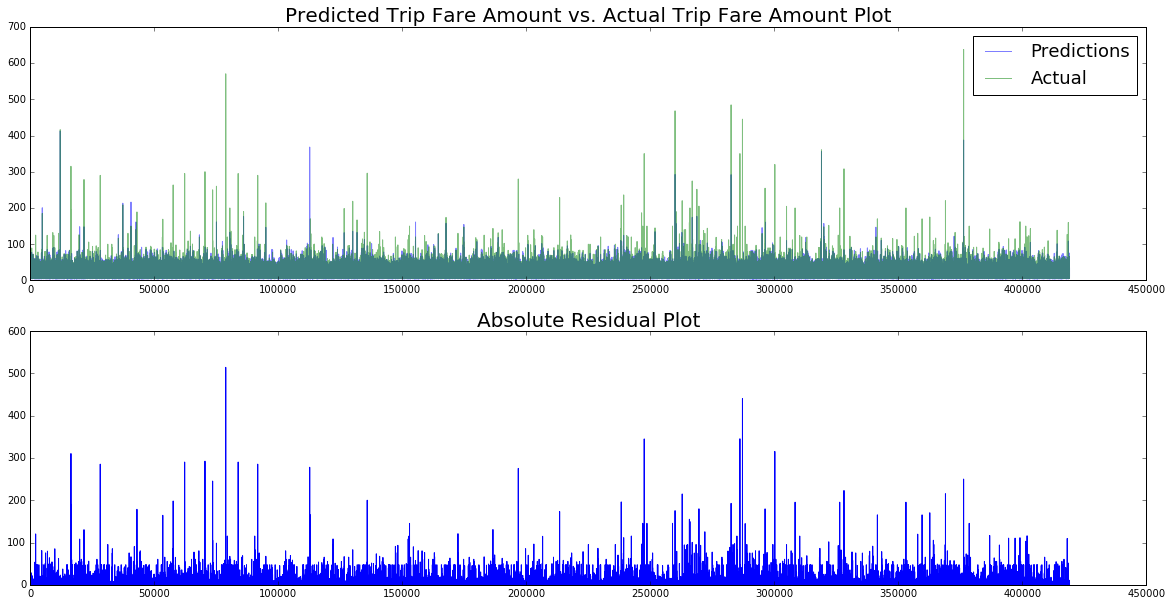

In [5]:
dt=preprocess_data(inputdf,min_fare_amount)
X_train,X_test,y_train,y_test=split_data(dt,features=['trip_distance'],train_percentage=0.5)
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
evaluate_linreg(lin_reg,X_test,y_test)

In [6]:
dt[['trip_distance','trip_duration_minutes','TimeOfDay','fare_amount']].head()

,trip_distance,trip_duration_minutes,TimeOfDay,fare_amount
0,90.41,66.116667,1,404.5
4,2.08,6.983333,1,8.5
6,2.30,10.116667,1,10.0
7,4.85,15.716667,1,16.5
9,1.26,4.000000,1,6.0


# Add Time of Trip Duration Feature.

Mean Squared Error 21.0225812099
R2 0.77297353988


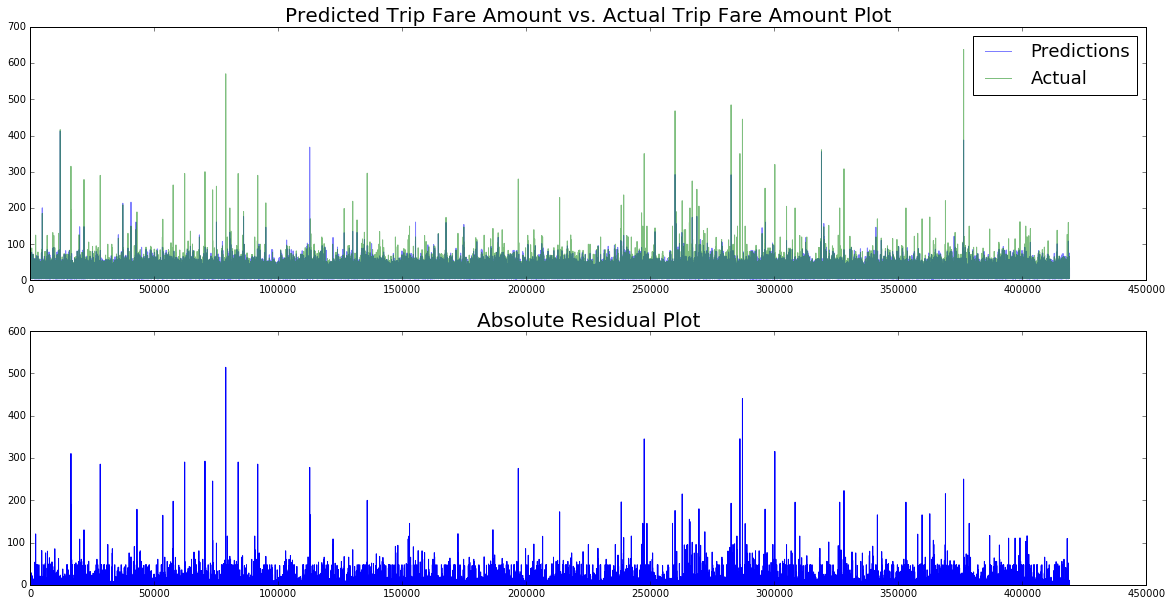

In [7]:
dt=preprocess_data(inputdf,min_fare_amount)
X_train,X_test,y_train,y_test=split_data(dt,features=['trip_distance','trip_duration_minutes'],train_percentage=0.5)
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
evaluate_linreg(lin_reg,X_test,y_test)

# Add Categorical Time of Day Feature

Mean Squared Error 21.0194254708
R2 0.773007619247


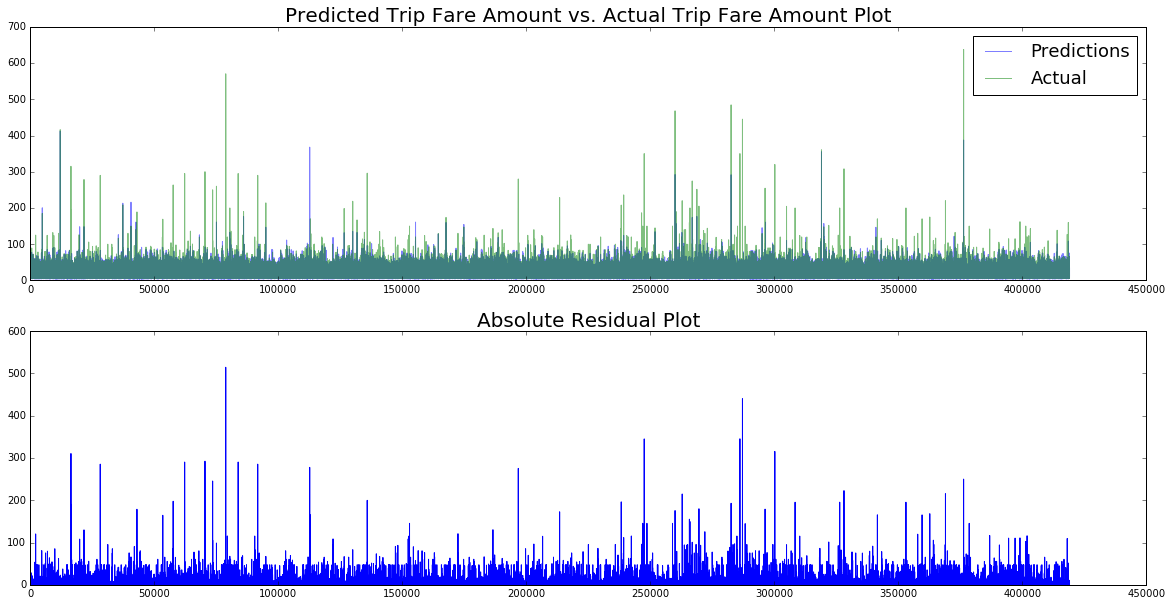

In [8]:
dt=preprocess_data(inputdf,min_fare_amount)
X_train,X_test,y_train,y_test=split_data(dt,features=['trip_distance','trip_duration_minutes','TimeOfDay'],
                                         train_percentage=0.5)
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
evaluate_linreg(lin_reg,X_test,y_test)

# KNN Regression

In [1]:
dt=preprocess_data(inputdf,min_fare_amount)
X_train,X_test,y_train,y_test=split_data(dt,features=['trip_distance'],train_percentage=0.5)
knn_reg=KNeighborsRegressor(n_neighbors=10)
knn_reg.fit(X_train,y_train)
evaluate_linreg(knn_reg,X_test,y_test)

NameError: name 'preprocess_data' is not defined

Mean Squared Error 14.5179609183
R2 0.843218050032


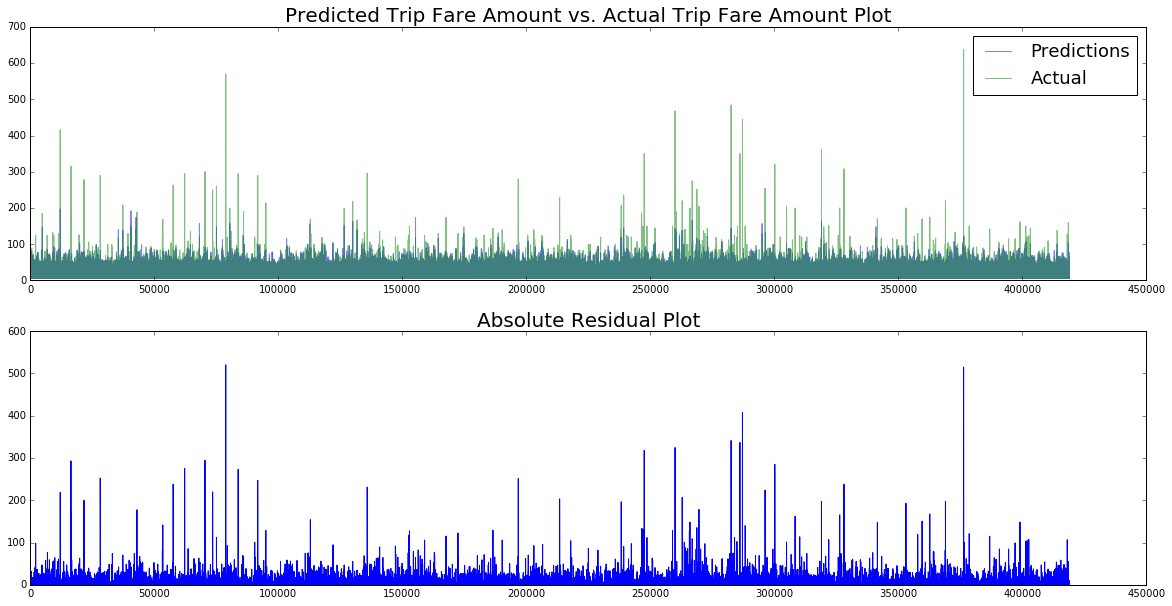

In [10]:
dt=preprocess_data(inputdf,min_fare_amount)
X_train,X_test,y_train,y_test=split_data(dt,features=['trip_distance','trip_duration_minutes'],train_percentage=0.5)
knn_reg=KNeighborsRegressor(n_neighbors=10)
knn_reg.fit(X_train,y_train)
evaluate_linreg(knn_reg,X_test,y_test)

Mean Squared Error 14.3981899776
R2 0.844511476963


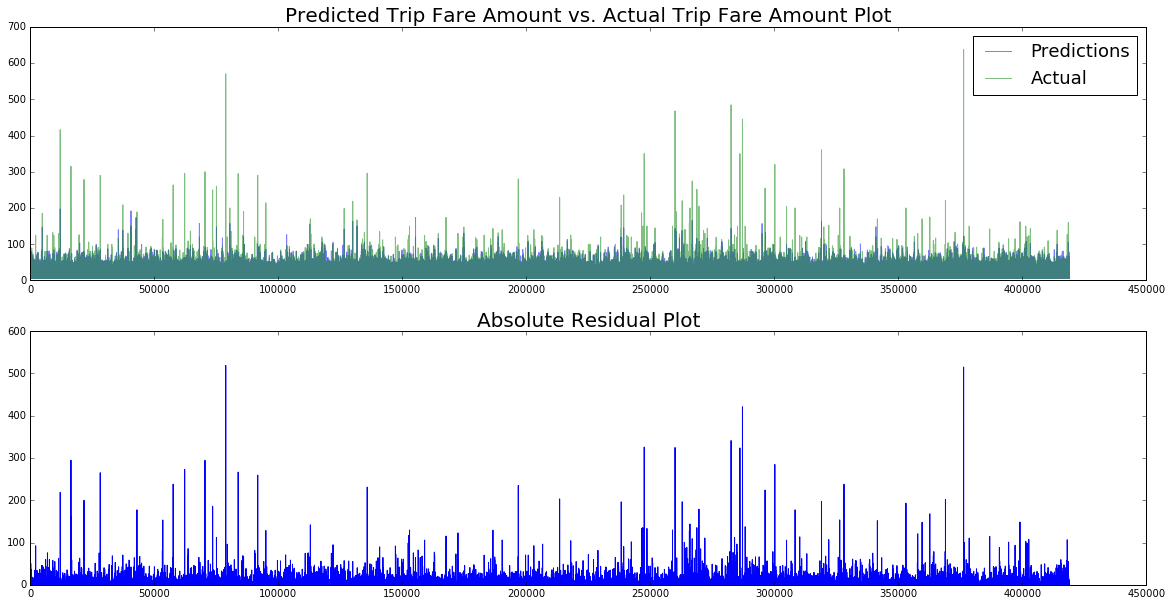

In [11]:
dt=preprocess_data(inputdf,min_fare_amount)
X_train,X_test,y_train,y_test=split_data(dt,features=['trip_distance','trip_duration_minutes','TimeOfDay'],train_percentage=0.5)
knn_reg=KNeighborsRegressor(n_neighbors=10)
knn_reg.fit(X_train,y_train)
evaluate_linreg(knn_reg,X_test,y_test)

# Classification

# Preceptron

In [12]:
import sklearn
import graphviz
import sklearn.tree
import numpy as np
from io import StringIO
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
import warnings
from sklearn import metrics
from sklearn.cross_validation import train_test_split,ShuffleSplit,cross_val_predict
warnings.filterwarnings('ignore')

In [13]:
# 2 Class Classification
def categorize_fare_amounts(amount):
    if (amount > 0) and (amount<=15):
        return 0  #Small Fare
    elif (amount>15): 
        return 1 #High Fare

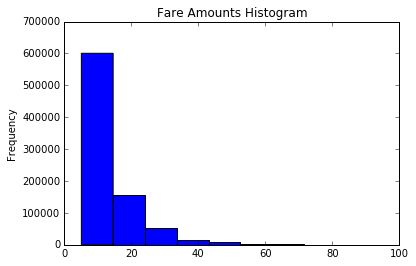

In [14]:
dt=preprocess_data(inputdf,min_fare_amount)
dt=dt[(dt['fare_amount']>0)&(dt['fare_amount']<100)]  #Only consider rows where the row value is between 0 and 100.
dt['fare_amount'].plot(kind='hist',title="Fare Amounts Histogram")

In [15]:
dt['fare_class']=dt['fare_amount'].apply(lambda x: categorize_fare_amounts(x))
dt[['fare_amount','fare_class']].head()

,fare_amount,fare_class
4,8.5,0
6,10.0,0
7,16.5,1
9,6.0,0
17,6.0,0


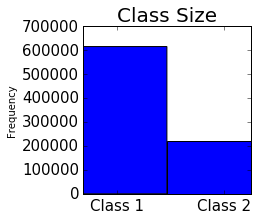

In [16]:
fig,ax=plt.subplots(1,1,figsize=(3,3))
ax.set_xticks([0.2,0.84])
ax.set_xticklabels(['Class 1','Class 2'],fontsize=15)
dt['fare_class'].plot(kind='hist',bins=2,ax=ax,fontsize=15)
ax.set_title("Class Size",fontsize=20)

In [17]:
#A Perceptron is a simple linear classifier.
clf = Perceptron(n_iter=100, verbose=0, random_state=None, fit_intercept=True, eta0=0.002) #Instantiate Perceptron
X_train, X_test, y_train, y_test = train_test_split(dt['trip_distance'],dt['fare_class'], 
                                                    test_size=0.5,random_state=42) #split data into 50% train and test.
clf.fit(X_train.as_matrix().reshape(-1,1),y_train)  #Fit the perceptron classifier using trip_distance.
preds=clf.predict(X_test.as_matrix().reshape(-1,1))  #Predict Output Class (0 or 1) for test data.
accuracy_met=metrics.accuracy_score(preds,y_test) # Calculate Accuracy of the model by comparing with actual targets.
print("Test Accuracy",accuracy_met)
print(metrics.classification_report(preds,y_test)) #Calculate Precision , Recall , F1-Score

Test Accuracy 0.862015777812
             precision    recall  f1-score   support

          0       0.83      0.98      0.90    259007
          1       0.96      0.67      0.79    159809

avg / total       0.88      0.86      0.86    418816



# Multi Class Classification

# Multi Layer Perceptron

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.cross_validation import train_test_split,ShuffleSplit,cross_val_predict

In [19]:
#Multiclass Classification
def categorize_fare_amounts(amount):
    if (amount > 0) and (amount<=10):
        return 1  #Small Fare
    elif (amount>10) and (amount<=30):
        return 2 #Medium Fare
    elif (amount>30): 
        return 3 #High Fare

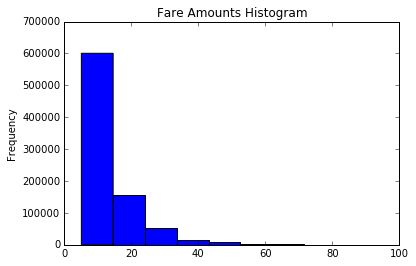

In [20]:
dt=dt[(dt['fare_amount']>0)&(dt['fare_amount']<100)]  #Only consider rows where the row value is between 0 and 100.
dt['fare_amount'].plot(kind='hist',title="Fare Amounts Histogram")

In [21]:
dt['fare_class']=dt['fare_amount'].apply(lambda x: categorize_fare_amounts(x))
dt[['fare_amount','fare_class']].head()

,fare_amount,fare_class
4,8.5,1
6,10.0,1
7,16.5,2
9,6.0,1
17,6.0,1


In [22]:
dt[['trip_distance','fare_amount','fare_class']].head()

,trip_distance,fare_amount,fare_class
4,2.08,8.5,1
6,2.30,10.0,1
7,4.85,16.5,2
9,1.26,6.0,1
17,1.08,6.0,1


In [23]:
clf=MLPClassifier()
clf = MLPClassifier(hidden_layer_sizes=(10,4,5))   #3 hidden layers with 10,4,5 nodes respectively. 
X_train, X_test, y_train, y_test = train_test_split(dt['trip_distance'],dt['fare_class'], 
                                                    test_size=0.5,random_state=42)
clf.fit(X_train.as_matrix().reshape(-1,1),y_train) #Fit the data to MLP classifier model.
preds=clf.predict(X_test.as_matrix().reshape(-1,1)) # Predict test data classes.
accuracy_met=metrics.accuracy_score(preds,y_test) #Calculate accuracy by comparing predictions with actual values.
print("Test Accuracy",accuracy_met) 
print(metrics.classification_report(preds,y_test)) #Calculate , Precision, Recall and F1-Score

Test Accuracy 0.898640453087
             precision    recall  f1-score   support

          1       0.95      0.89      0.92    221863
          2       0.87      0.91      0.89    181516
          3       0.67      0.91      0.77     15437

avg / total       0.90      0.90      0.90    418816



# KNN Classifier

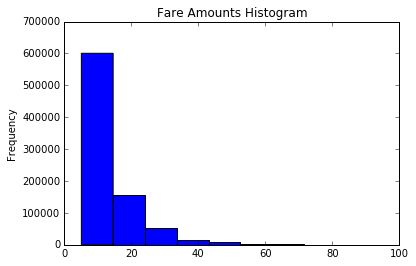

In [24]:
dt=dt[(dt['fare_amount']>0)&(dt['fare_amount']<100)]  #Only consider rows where the row value is between 0 and 100.
dt['fare_amount'].plot(kind='hist',title="Fare Amounts Histogram")

In [25]:
dt[['trip_distance','fare_amount','fare_class']].head()

,trip_distance,fare_amount,fare_class
4,2.08,8.5,1
6,2.30,10.0,1
7,4.85,16.5,2
9,1.26,6.0,1
17,1.08,6.0,1


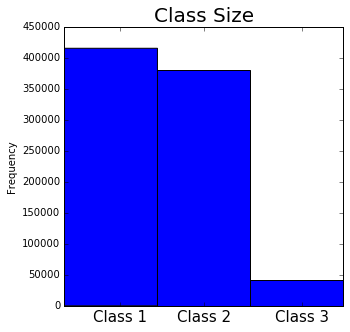

In [26]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.set_xticks([1.4,2.0,2.7])
ax.set_xticklabels(['Class 1','Class 2','Class 3'],fontsize=15)
dt['fare_class'].plot(kind='hist',bins=3,ax=ax)
ax.set_title("Class Size",fontsize=20)

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cross_validation import train_test_split,ShuffleSplit,cross_val_predict

In [28]:
def cross_val_tune_n_neighbors(X_train,y_train):
    num_neighbors=list()
    for j in range(1,5):
        print("Iter",j)
        max_acc=0.0
        max_acc_idx=0.9
        for i in range(1,10):
            clf=KNeighborsClassifier(n_neighbors=i)
            _x_tr,_x_test,_y_tr,_y_test=train_test_split(X_train,y_train,test_size=0.4)
            #print(sorted(_x_tr.values))
            clf.fit(_x_tr,_y_tr)
            predicted = clf.predict(_x_test)
            acc=metrics.accuracy_score(predicted,_y_test)
            if acc>max_acc:
                max_acc_idx=i
                max_acc=acc
        num_neighbors.append(max_acc_idx)
        print("Optimal Num Neighbors",max_acc_idx,"\n======================================")
    from collections import Counter
    c=Counter(num_neighbors)
    print("Optimal Number of Nearest Neighbors",c.most_common(1)[0][0])

In [29]:
_dt=dt.dropna(subset=['fare_amount','fare_class'])
X_train, X_test, y_train, y_test = train_test_split(_dt[['trip_distance']],_dt[['fare_class']], test_size=0.5, 
                                                    random_state=42)
cross_val_tune_n_neighbors(X_train,y_train)

Iter 1
Optimal Num Neighbors 7 
Iter 2
Optimal Num Neighbors 9 
Iter 3
Optimal Num Neighbors 7 
Iter 4
Optimal Num Neighbors 9 
Optimal Number of Nearest Neighbors 9


In [30]:
#Test Accuracy
clf=KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train,y_train)
preds=clf.predict(X_test)
accuracy_met=metrics.accuracy_score(preds,y_test)
print("Test Accuracy",accuracy_met)

Test Accuracy 0.891033293857


In [31]:
print(metrics.classification_report(preds,y_test))

             precision    recall  f1-score   support

          1       0.93      0.90      0.91    215065
          2       0.87      0.89      0.88    187082
          3       0.69      0.86      0.77     16669

avg / total       0.89      0.89      0.89    418816



# PCA

In [32]:
from sklearn.decomposition import PCA

In [33]:
X = dt[['trip_distance','trip_duration_minutes','TimeOfDay','fare_amount','tip_amount','tolls_amount']]
y = dt['fare_class']-1
target_names = ['Small','Medium','High']

def run_PCA(X,y,target_names,ncomponents=2):
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))
    plt.figure(figsize=(8,8))
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2

    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA Visualization of NYC Green Taxi dataset')
    plt.show()

explained variance ratio (first two components): [ 0.99094228  0.00835339]


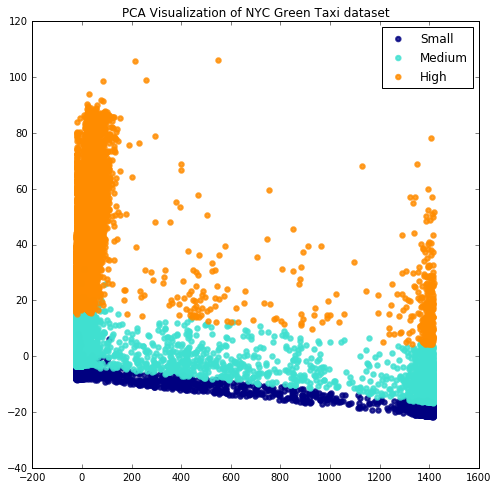

In [34]:
run_PCA(X,y,target_names,ncomponents=2)

# K-Means

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd  #requirement comes with anaconda
import datetime 
import seaborn as sns
import operator
import numpy as np
import geopandas as gp #might need to install separately.
import sys
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2
from utils import citibike_helpers
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
inputfile="../datasets/citibike/201701-citibike-tripdata.csv.gz"
df=citibike_helpers.load_citibike_data(inputfile)
df.head(2)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2


In [37]:
unique_start_stations=citibike_helpers.get_unique_column_values(df,'Start Station ID')
unique_end_stations=citibike_helpers.get_unique_column_values(df,'End Station ID')
station_ids=set(unique_start_stations).union(set(unique_end_stations))
geo_stations=citibike_helpers.create_geodf_citibike_nyc(df,station_ids)
geo_stations.head(2)

,index,geometry,station_ids
0,0,POINT (-73.99392888 40.76727216),72
1,1,POINT (-74.00666661 40.71911552),79


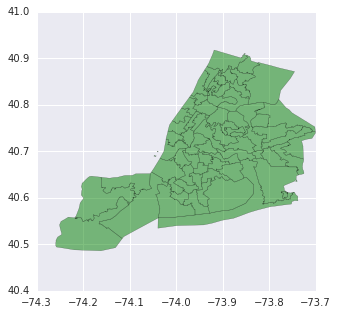

In [38]:
shp_nyc = gp.GeoDataFrame.from_file('../datasets/citibike/nyc_shapefiles/nyadwi.shp')
shp_nyc=shp_nyc.to_crs({'init':'epsg:4326'})
shp_nyc.plot(figsize=(5,5),color='g',alpha=0.5)

In [39]:
stnlatlon=list()
for key,grp in df.groupby('Start Station ID'):
    lat=grp['Start Station Latitude'].unique()[0]
    lon=grp['Start Station Longitude'].unique()[0]
    stnlatlon.append({'stn':key,'lat':lat,'lon':lon})

In [40]:
stnlatlon_df=pd.DataFrame(stnlatlon)
stnlatlon_df.head()

,lat,lon,stn
0,40.767272,-73.993929,72
1,40.719116,-74.006667,79
2,40.711174,-74.000165,82
3,40.683826,-73.976323,83
4,40.741776,-74.001497,116


In [41]:
colors='rgbykc'
#Run K-Means Clustering With a variable number of clusters.
def kmeans_plot(stnlatlon_df,geo_stations):
    clrs=list()
    for i in list(range(geo_stations.shape[0])):
        label=stnlatlon_df[stnlatlon_df.stn==geo_stations.iloc[i]['station_ids']]['kmeans_labels'].values
        if label.shape[0]>0:
            clrs.append(colors[label[0]])
        else:
            clrs.append('r') 

    fig, ax = plt.subplots(1,1,figsize=(20,20))
    base = shp_nyc.plot(ax=ax, color='gray', alpha=0.2)
    geo_stations.plot(ax=base, marker="o", color=clrs, markersize=35,alpha=0.8, zorder=0)
    _ = ax.axis('off')
        
def run_kmeans(stnlatlon_df,geo_stations):
    for j in range(2,7):  #Iterate Varying the number of clusters
        km=KMeans(n_clusters=j)  #Instantiate KMeans Object from sklearn.cluster
        km.fit(stnlatlon_df[['lat','lon']])   #fit the model to the lat,lon dataframe.
        stnlatlon_df['kmeans_labels']=km.labels_   #extract cluster labels that have been assigned to each point.
        kmeans_plot(stnlatlon_df,geo_stations)
        

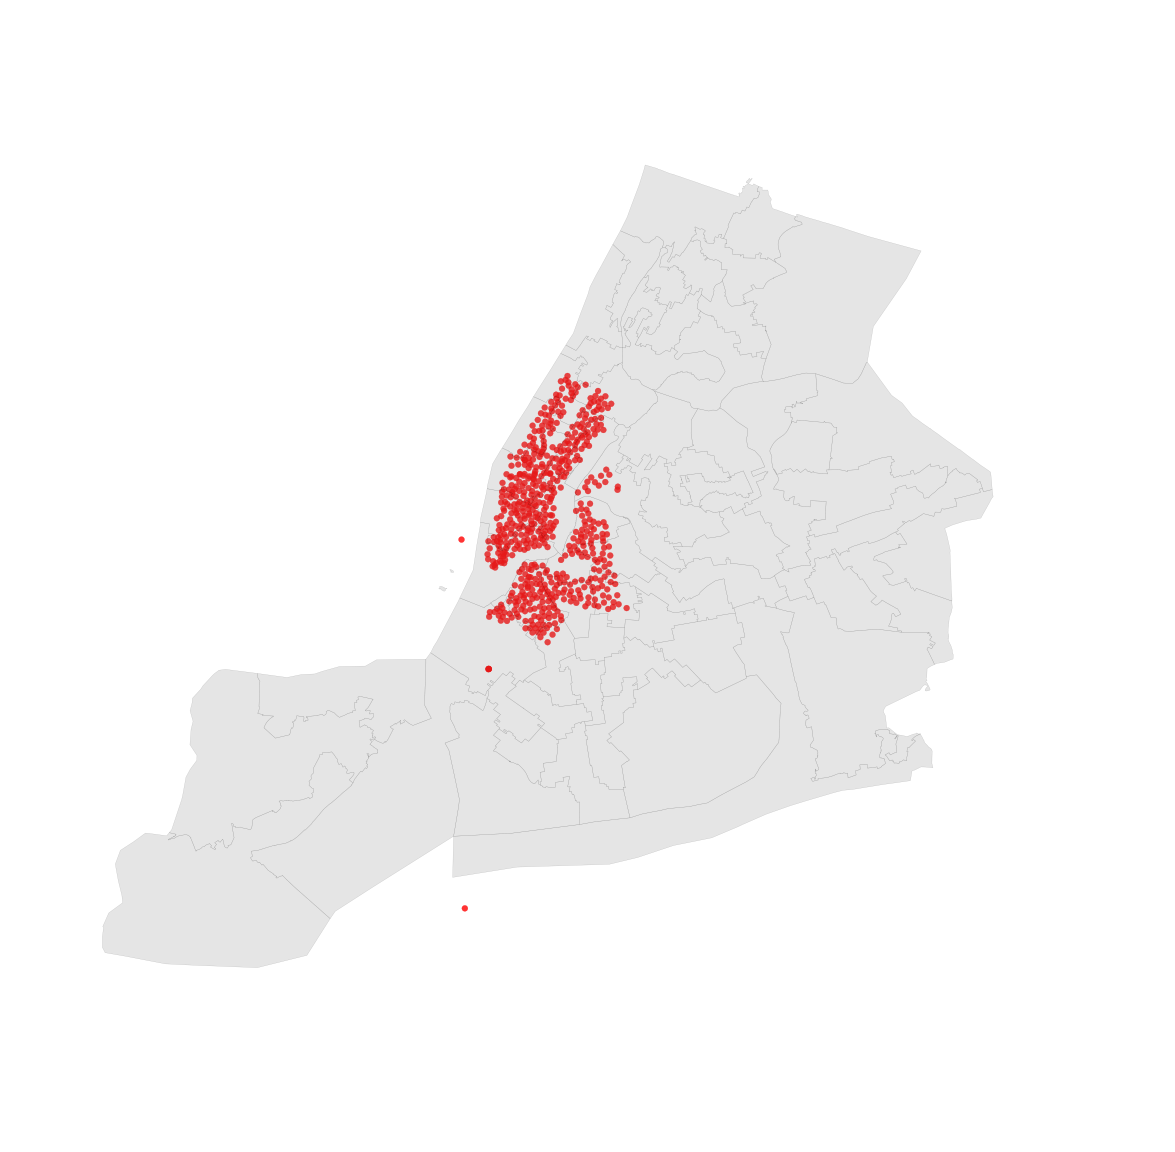

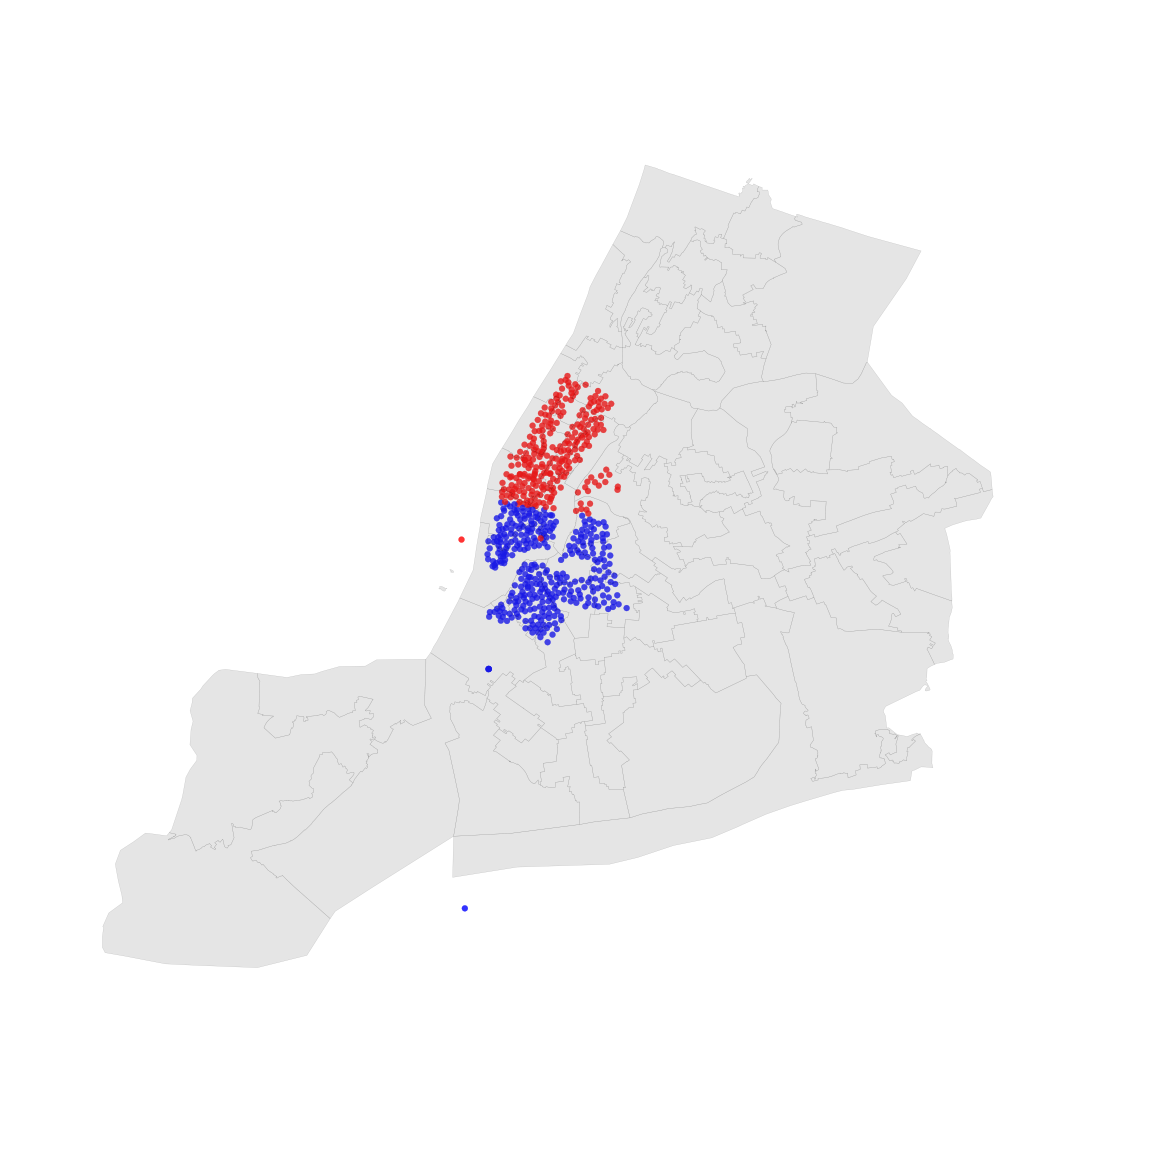

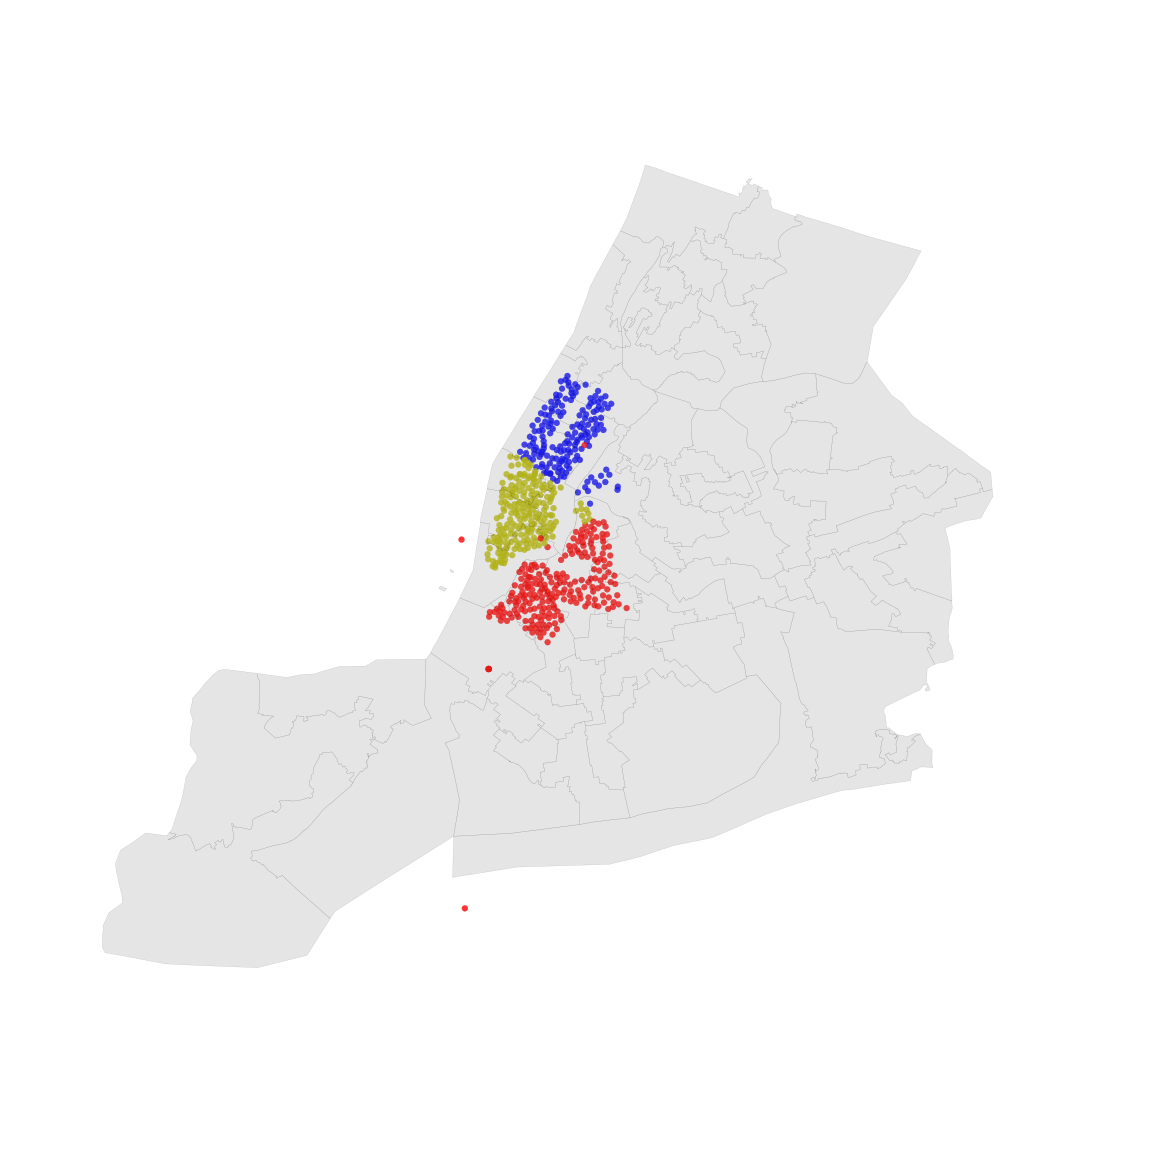

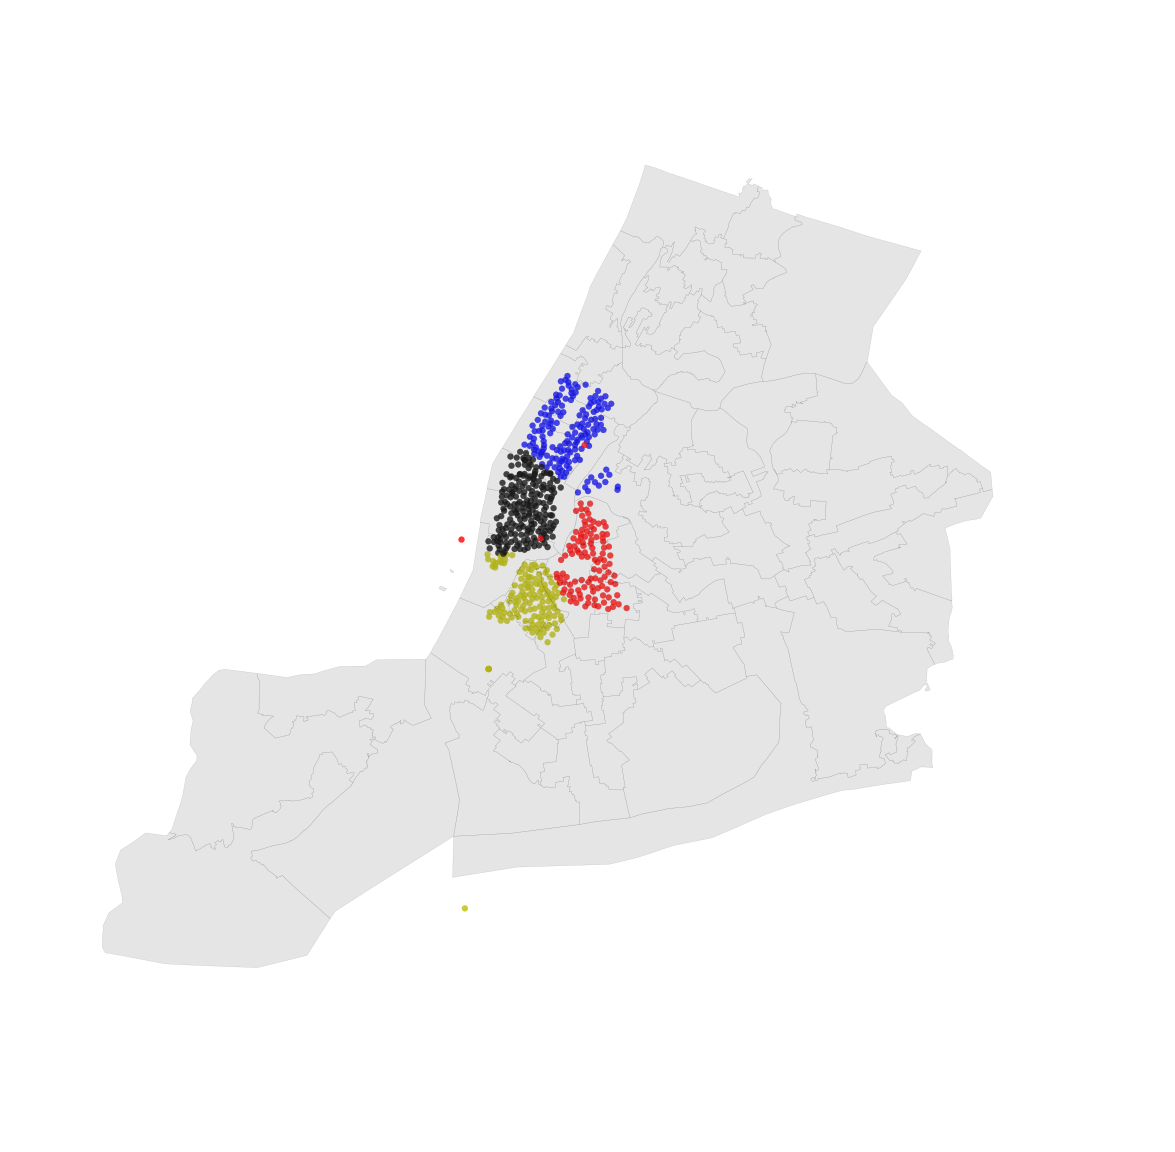

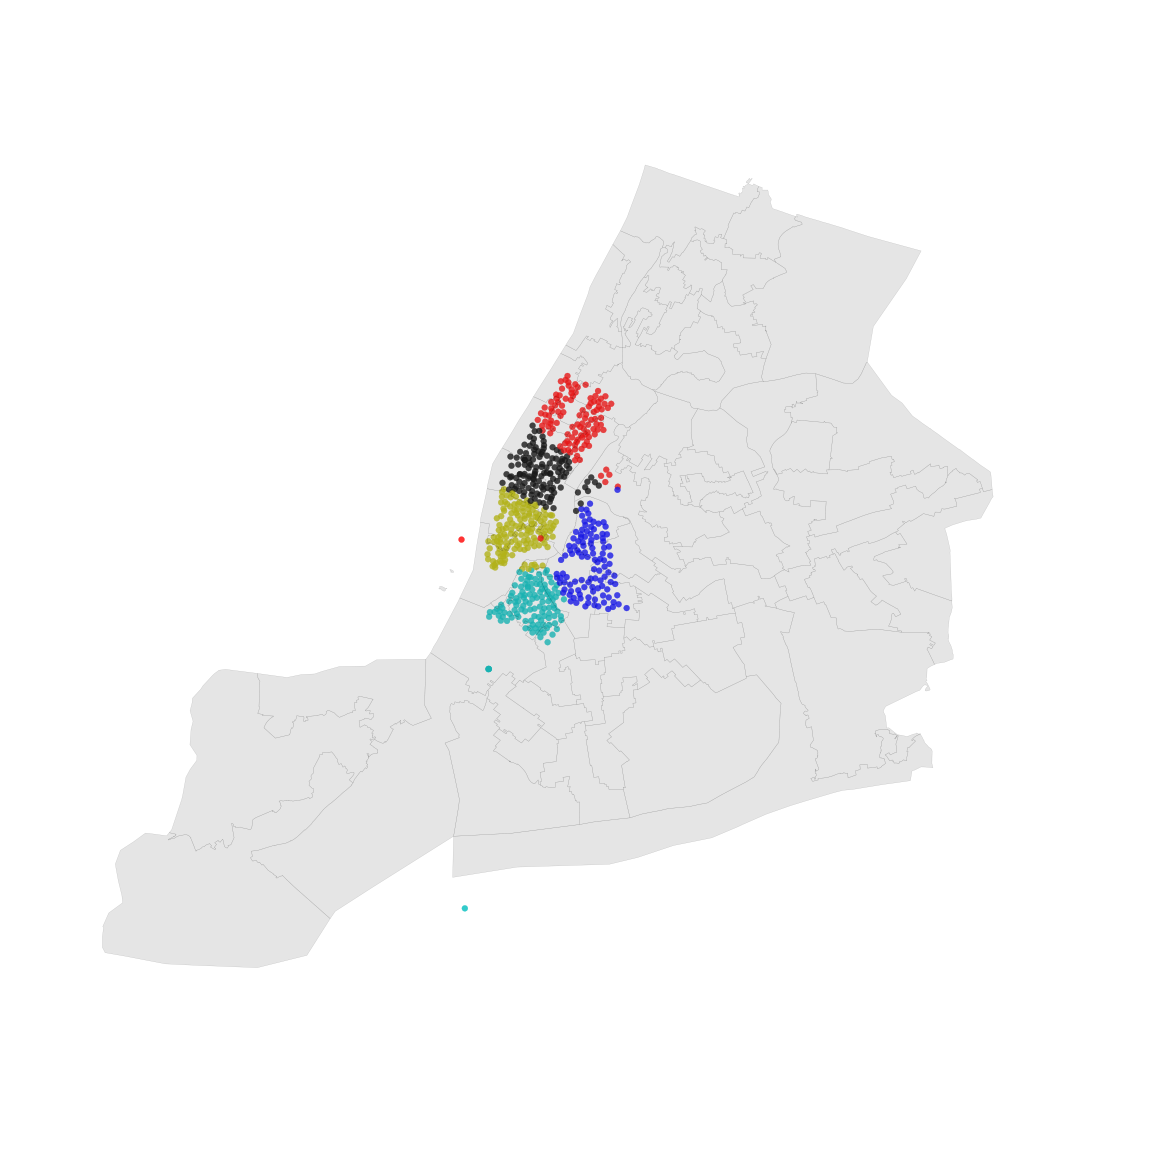

In [42]:
run_kmeans(stnlatlon_df,geo_stations)